In [1]:
import os
import cv2
import numpy as np
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
from statistics import mean

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset

D:\Users\Alex\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import torchvision

import torchvision.transforms as transforms
import torchvision.datasets as datasets

In [3]:
from functions_v2 import(import_train_folder_dataset_2, 
                      Data_2, 
                      plot_loss_accuracy, 
                      accuracy_given_set,
                      import_test_folder_dataset_2,
                      Data_test_2,
                      make_predictions,
                      save_predictions_as_csv,
                      save_model,
                      save_metrics)

# 1. Build your own convolutional neural network using pytorch

In [4]:
# Learning parameters.
epochs = 500 # Number of epochs to train the model
lr = 0.01 # Learning rate.
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)


TRAIN_BATCH_SIZE = 16
TEST_BATCH_SIZE = 8

checkpoints_save = 100 # Save after 100 epochs


model_checkpoints = "D:/Personal/Alex/Uni/MS IA/2 Curso/Fall 2022/Computer Vision/Project/Project 1/CheckPoints/"

cuda


In [5]:
#PyTorch - Building the Model
class ClassificationNet(nn.Module):
    def __init__(self):
        super(ClassificationNet, self).__init__()
        
        '''
        In dimension:              224 * 224 * 3 
        Out dimension Conv:        224 * 224 * 6
        Out dimension MaxPooling:  112 * 112 * 6
        '''
        self.cnn1_model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=6, kernel_size=9, stride=1, padding=4),
            nn.ReLU(),
            nn.Conv2d(in_channels=6, out_channels=6, kernel_size=3, stride=1, padding=1)
        )
        self.batch1 = nn.BatchNorm2d(6)
        self.maxpool1 = nn.MaxPool2d(2, stride=2)
        
        
        '''
        In dimension:              112 * 112 * 6 
        Out dimension Conv:        112 * 112 * 9
        Out dimension MaxPooling:  56  * 56  * 9
        '''
        self.cnn2_model = nn.Sequential(
            nn.Conv2d(in_channels=6, out_channels=9, kernel_size=9, stride=1, padding=4),
            nn.ReLU(),
            nn.Conv2d(in_channels=9, out_channels=9, kernel_size=3, stride=1, padding=1)
        )
        self.batch2 = nn.BatchNorm2d(9)
        self.maxpool2 = nn.MaxPool2d(2, stride=2)
        
        '''
        In dimension:              56  * 56  * 9
        Out dimension Conv:        56  * 56  * 12
        Out dimension MaxPooling:  28  * 28  * 12
        '''
        self.cnn3_model = nn.Sequential(
            nn.Conv2d(in_channels=9, out_channels=12, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=12, out_channels=12, kernel_size=3, stride=1, padding=1)
        )
        self.batch3 = nn.BatchNorm2d(12)
        self.maxpool3 = nn.MaxPool2d(2, stride=2)
        
        '''
        In dimension:              28  * 28  * 12
        Out dimension Conv:        28  * 28  * 15
        Out dimension MaxPooling:  7  * 7  * 15
        '''
        self.cnn4_model = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=15, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=15, out_channels=15, kernel_size=3, stride=1, padding=1)
        ) 
        self.batch4 = nn.BatchNorm2d(15)
        self.maxpool4 = nn.MaxPool2d(4, stride=4)
        
        
        
        self.ffnn_model = nn.Sequential(
            nn.Linear(in_features=735, out_features=128),
            nn.Dropout(0.4),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=4)
        )
        
        
        
    def forward(self, x): 
        
        # Convolution
        x = self.cnn1_model(x)
        x = self.batch1(x)
        x = F.relu(x) 
        # Max pooling
        x = self.maxpool1(x)
        
        
        # Convolution
        x = self.cnn2_model(x)
        x = self.batch2(x)
        x = F.relu(x) 
        # Max pooling
        x = self.maxpool2(x)
        
        
        # Convolution
        x = self.cnn3_model(x)
        x = self.batch3(x)
        x = F.relu(x) 
        # Max pooling
        x = self.maxpool3(x)
        
        
        # Convolution
        x = self.cnn4_model(x)
        x = self.batch4(x)
        x = F.relu(x) 
        # Max pooling
        x = self.maxpool4(x)
        
        
        x = torch.flatten(x,start_dim=1)
        #print("Flatten Out: ",x.shape)
        x = self.ffnn_model(x)
        #print("ffnn out: ",x.shape)
        x = torch.sigmoid(x)
        #print("Sigmoid Out: ",x.shape)
        return x

In [6]:
#PyTorch - Visualizing the Model
modelpy = ClassificationNet().to(device) # Get the model, and if there is a GPU use it
print("model created")
# Loss function.
criterion = nn.CrossEntropyLoss() # Set the loss function to cross entropy loss
# Optimizer.
optim = torch.optim.SGD(modelpy.parameters(), lr=lr)# , momentum=0.9, weight_decay=1e-3


# Check if checkpoint is available, if so, load it
epoch_check = 0
previous_time = 0
names = os.listdir(model_checkpoints)
for elem in names:
    if(elem=="model_ckpt.pth"):
        print("Loading save chackpoint")
        checkpoint = torch.load(model_checkpoints + "model_ckpt.pth")
        modelpy.load_state_dict(checkpoint['model_state_dict'])
        modelpy.to(device)
        optim.load_state_dict(checkpoint['optimizer_state_dict'])
        epoch_check = checkpoint['epoch']
        criterion = checkpoint['loss']
        previous_time = checkpoint['time']
        print(f"Epoch of the checkpoint: {epoch_check}")


modelpy

model created
Loading save chackpoint
Epoch of the checkpoint: 400


ClassificationNet(
  (cnn1_model): Sequential(
    (0): Conv2d(3, 6, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
    (1): ReLU()
    (2): Conv2d(6, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (batch1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2_model): Sequential(
    (0): Conv2d(6, 9, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
    (1): ReLU()
    (2): Conv2d(9, 9, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (batch2): BatchNorm2d(9, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn3_model): Sequential(
    (0): Conv2d(9, 12, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (batch3): BatchNorm2d(12, eps=1e-0

In [7]:
# Model Parameters

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f"Model Parameters: {count_parameters(modelpy)}")

Model Parameters: 112298


# Load Data

In [8]:
# Path of the files
train_data_path = "D:/Personal/Alex/Uni/MS IA/2 Curso/Fall 2022/Artificial Intelligence/Projects/Project 1/data/Train"
test_data_path = "D:/Personal/Alex/Uni/MS IA/2 Curso/Fall 2022/Artificial Intelligence/Projects/Project 1/data/Test"

In [9]:
img_transform = transforms.Compose([transforms.ToPILImage(),
                                    transforms.RandomRotation((-20,20)),
                                    transforms.Resize((275, 275)),
                                    #transforms.CenterCrop((224, 224)),
                                    transforms.RandomCrop((224, 224)),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

img_transform_val = transforms.Compose([transforms.ToPILImage(),
                                        transforms.Resize((224, 224)),
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

In [10]:
# Import the data into a resized 224x224 images
size_of_resized_img = (224,224) 
train_data, train_labels = import_train_folder_dataset_2(train_data_path, resized_side=size_of_resized_img)
print("Dim of Data: ", train_data.shape)
print("Dim of Lables: ", train_labels.shape)

Dim of Data:  (1149, 224, 224, 3)
Dim of Lables:  (1149,)


In [11]:
# Split into Train, Validation
X_train, X_val, y_train, y_val = train_test_split(train_data, train_labels, test_size=0.1, random_state=42)
print("Dim of Data: ", X_train.shape)
print("Dim of Lables: ", y_train.shape)
print("Dim of X_test: ", X_val.shape)
print("Dim of y_test: ", y_val.shape)

Dim of Data:  (1034, 224, 224, 3)
Dim of Lables:  (1034,)
Dim of X_test:  (115, 224, 224, 3)
Dim of y_test:  (115,)


In [12]:
# Create the dataset object
train_Dataset = Data_2(X_train, y_train, img_transform) # img_transform_2 img_transform
val_Dataset = Data_2(X_val, y_val, img_transform_val)

print("Train len: ",len(train_Dataset))
print("Val len: ",len(val_Dataset))

Train len:  1034
Val len:  115


In [13]:
# Create the dataloaders
train_loader = DataLoader(
    train_Dataset, 
    batch_size=TRAIN_BATCH_SIZE,             
    shuffle=True)

valid_loader = DataLoader(
    val_Dataset, 
    batch_size=TEST_BATCH_SIZE,
    shuffle=False
    )

In [14]:
print("Type of object: ",type(train_loader))

print()
print( 'Train Size: ' + str(len(train_loader)))
print( 'Validate Size: ' + str(len(valid_loader)))

print()
print("Content of one element: ",iter(train_loader).next())

print()
print("Type of one element: ", type(iter(train_loader).next()))
print("Length of one element: ", len(iter(train_loader).next()))

print()
print('Input tensors size: ' + str(iter(train_loader).next()[0].shape)) # Input: 16, 16875 | 16 train batch size, 16875 = 75x75 image dimension, 3 channels (colors) 
print('Label tensors size: ' + str(iter(train_loader).next()[1].shape)) # Label: 16 | 16 train Batch size


print()
print('Input tensors size: ' + str(iter(valid_loader).next()[0].shape)) # Input: 8, 16875 | 8 validation batch size, 16875 = 75x75 image dimension, 3 channels (colors) 
print('Label tensors size: ' + str(iter(valid_loader).next()[1].shape)) # Label: 8 | 8 validation Batch size


Type of object:  <class 'torch.utils.data.dataloader.DataLoader'>

Train Size: 65
Validate Size: 15

Content of one element:  [tensor([[[[-1.7412, -1.7754, -1.8268,  ..., -2.1179, -2.1179, -2.1179],
          [-1.7240, -1.7583, -1.8097,  ..., -2.1179, -2.1179, -2.1179],
          [-1.7240, -1.7583, -1.8097,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-1.4500, -1.5014, -1.5014,  ..., -1.5185, -1.5357, -1.5699],
          [-1.4843, -1.5185, -1.5185,  ..., -1.5014, -1.5185, -1.5357],
          [-1.5014, -1.5357, -1.5185,  ..., -1.5185, -1.5185, -1.5185]],

         [[-1.2829, -1.3179, -1.3704,  ..., -2.0357, -2.0357, -2.0357],
          [-1.2654, -1.3004, -1.3529,  ..., -2.0357, -2.0357, -2.0357],
          [-1.2654, -1.3004, -1.3529,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [-1.0728, -1.1253, -1.1253,  ..., -1.1604, -1.1779, -1.2129],
          [-1.1078, -1.1604, -1.1429,  ..., -1.1429, -1.1604, -1.1779],
          [-1.1253, -1.1604, -1.1429,  ..., -1.16

# 2. Train your model using cow teat datasets (you may need to use  Google Colab (or Kaggle) with GPU to train your code) 

Loading Metrics

Epoch 401 of 500


100%|██████████| 15/15 [00:00<00:00, 29.38it/s]


train loss:  0.06249709851045442
Val loss:  0.1350259718687638
train accuracy:  0.6663442940038685
Val accuracy:  0.6782608695652174
Current time: 79.961 minutes. Time expected till completion: 19.741 minutes

Epoch 402 of 500


100%|██████████| 15/15 [00:00<00:00, 35.98it/s]


train loss:  0.06223629873310805
Val loss:  0.13311217712319415
train accuracy:  0.660541586073501
Val accuracy:  0.6695652173913044
Current time: 80.120 minutes. Time expected till completion: 19.532 minutes

Epoch 403 of 500


100%|██████████| 15/15 [00:00<00:00, 31.33it/s]


train loss:  0.06277503035746414
Val loss:  0.13538181263467539
train accuracy:  0.6528046421663443
Val accuracy:  0.6869565217391305
Current time: 80.284 minutes. Time expected till completion: 19.324 minutes

Epoch 404 of 500


100%|██████████| 15/15 [00:00<00:00, 30.32it/s]


train loss:  0.06290940113178305
Val loss:  0.13713344439216282
train accuracy:  0.6547388781431335
Val accuracy:  0.6521739130434783
Current time: 80.454 minutes. Time expected till completion: 19.118 minutes

Epoch 405 of 500


100%|██████████| 15/15 [00:00<00:00, 30.69it/s]


train loss:  0.06283054447496883
Val loss:  0.13712882943775342
train accuracy:  0.6518375241779497
Val accuracy:  0.6608695652173913
Current time: 80.634 minutes. Time expected till completion: 18.914 minutes

Epoch 406 of 500


100%|██████████| 15/15 [00:00<00:00, 32.00it/s]


train loss:  0.06264050330829805
Val loss:  0.13933977614278378
train accuracy:  0.6547388781431335
Val accuracy:  0.6608695652173913
Current time: 80.815 minutes. Time expected till completion: 18.711 minutes

Epoch 407 of 500


100%|██████████| 15/15 [00:00<00:00, 28.81it/s]


train loss:  0.06232477813901477
Val loss:  0.1341543182082798
train accuracy:  0.6673114119922631
Val accuracy:  0.6608695652173913
Current time: 80.998 minutes. Time expected till completion: 18.508 minutes

Epoch 408 of 500


100%|██████████| 15/15 [00:00<00:00, 29.26it/s]


train loss:  0.06265791011271671
Val loss:  0.13536972066630487
train accuracy:  0.660541586073501
Val accuracy:  0.6782608695652174
Current time: 81.189 minutes. Time expected till completion: 18.307 minutes

Epoch 409 of 500


100%|██████████| 15/15 [00:00<00:00, 31.01it/s]


train loss:  0.0628164323547592
Val loss:  0.13665429405544116
train accuracy:  0.660541586073501
Val accuracy:  0.6782608695652174
Current time: 81.373 minutes. Time expected till completion: 18.105 minutes

Epoch 410 of 500


100%|██████████| 15/15 [00:00<00:00, 31.40it/s]


train loss:  0.06251546256316239
Val loss:  0.13622831209846165
train accuracy:  0.660541586073501
Val accuracy:  0.6782608695652174
Current time: 81.569 minutes. Time expected till completion: 17.905 minutes

Epoch 411 of 500


100%|██████████| 15/15 [00:00<00:00, 30.32it/s]


train loss:  0.06227465881830949
Val loss:  0.13497633830360745
train accuracy:  0.6615087040618955
Val accuracy:  0.6782608695652174
Current time: 81.752 minutes. Time expected till completion: 17.703 minutes

Epoch 412 of 500


100%|██████████| 15/15 [00:00<00:00, 30.69it/s]


train loss:  0.06183856794866418
Val loss:  0.13716264963150024
train accuracy:  0.6460348162475822
Val accuracy:  0.6782608695652174
Current time: 81.935 minutes. Time expected till completion: 17.501 minutes

Epoch 413 of 500


100%|██████████| 15/15 [00:00<00:00, 31.53it/s]


train loss:  0.06233113704382566
Val loss:  0.1370524525642395
train accuracy:  0.6644100580270793
Val accuracy:  0.6782608695652174
Current time: 82.119 minutes. Time expected till completion: 17.299 minutes

Epoch 414 of 500


100%|██████████| 15/15 [00:00<00:00, 27.85it/s]


train loss:  0.062481809227332846
Val loss:  0.13418283099713532
train accuracy:  0.660541586073501
Val accuracy:  0.6434782608695652
Current time: 82.301 minutes. Time expected till completion: 17.096 minutes

Epoch 415 of 500


100%|██████████| 15/15 [00:00<00:00, 29.78it/s]


train loss:  0.06296921946555088
Val loss:  0.1356926969859911
train accuracy:  0.6624758220502901
Val accuracy:  0.6695652173913044
Current time: 82.484 minutes. Time expected till completion: 16.894 minutes

Epoch 416 of 500


100%|██████████| 15/15 [00:00<00:00, 29.96it/s]


train loss:  0.0628621111294287
Val loss:  0.13436350044996842
train accuracy:  0.660541586073501
Val accuracy:  0.6782608695652174
Current time: 82.672 minutes. Time expected till completion: 16.693 minutes

Epoch 417 of 500


100%|██████████| 15/15 [00:00<00:00, 29.49it/s]


train loss:  0.06271892134640618
Val loss:  0.13481443602105844
train accuracy:  0.6663442940038685
Val accuracy:  0.6956521739130435
Current time: 82.854 minutes. Time expected till completion: 16.491 minutes

Epoch 418 of 500


100%|██████████| 15/15 [00:00<00:00, 30.14it/s]


train loss:  0.06231216587688291
Val loss:  0.13550804542458575
train accuracy:  0.6624758220502901
Val accuracy:  0.6782608695652174
Current time: 83.037 minutes. Time expected till completion: 16.290 minutes

Epoch 419 of 500


100%|██████████| 15/15 [00:00<00:00, 30.38it/s]


train loss:  0.06268170233851936
Val loss:  0.1332157570382823
train accuracy:  0.660541586073501
Val accuracy:  0.6869565217391305
Current time: 83.223 minutes. Time expected till completion: 16.088 minutes

Epoch 420 of 500


100%|██████████| 15/15 [00:00<00:00, 28.98it/s]


train loss:  0.06336223854317656
Val loss:  0.13672105903210846
train accuracy:  0.6566731141199227
Val accuracy:  0.6608695652173913
Current time: 83.408 minutes. Time expected till completion: 15.887 minutes

Epoch 421 of 500


100%|██████████| 15/15 [00:00<00:00, 31.40it/s]


train loss:  0.06276953376008187
Val loss:  0.13577289166657822
train accuracy:  0.655705996131528
Val accuracy:  0.6608695652173913
Current time: 83.590 minutes. Time expected till completion: 15.686 minutes

Epoch 422 of 500


100%|██████████| 15/15 [00:00<00:00, 29.96it/s]


train loss:  0.06261771006556498
Val loss:  0.13722159447877302
train accuracy:  0.6682785299806576
Val accuracy:  0.6782608695652174
Current time: 83.776 minutes. Time expected till completion: 15.485 minutes

Epoch 423 of 500


100%|██████████| 15/15 [00:00<00:00, 30.45it/s]


train loss:  0.061943780522743096
Val loss:  0.13505969565847645
train accuracy:  0.6702127659574468
Val accuracy:  0.6695652173913044
Current time: 83.962 minutes. Time expected till completion: 15.284 minutes

Epoch 424 of 500


100%|██████████| 15/15 [00:00<00:00, 30.02it/s]


train loss:  0.06284709744573332
Val loss:  0.13235392985136613
train accuracy:  0.6547388781431335
Val accuracy:  0.6782608695652174
Current time: 84.144 minutes. Time expected till completion: 15.082 minutes

Epoch 425 of 500


100%|██████████| 15/15 [00:00<00:00, 28.98it/s]


train loss:  0.06205084868049253
Val loss:  0.1346171337625255
train accuracy:  0.6624758220502901
Val accuracy:  0.6608695652173913
Current time: 84.329 minutes. Time expected till completion: 14.882 minutes

Epoch 426 of 500


100%|██████████| 15/15 [00:00<00:00, 30.45it/s]


train loss:  0.06243440866239758
Val loss:  0.13565154231112936
train accuracy:  0.6653771760154739
Val accuracy:  0.6869565217391305
Current time: 84.515 minutes. Time expected till completion: 14.681 minutes

Epoch 427 of 500


100%|██████████| 15/15 [00:00<00:00, 29.96it/s]


train loss:  0.06219669749935084
Val loss:  0.1343450401140296
train accuracy:  0.6673114119922631
Val accuracy:  0.6695652173913044
Current time: 84.697 minutes. Time expected till completion: 14.480 minutes

Epoch 428 of 500


100%|██████████| 15/15 [00:00<00:00, 31.53it/s]


train loss:  0.06244452150693484
Val loss:  0.1342515712199004
train accuracy:  0.6644100580270793
Val accuracy:  0.6782608695652174
Current time: 84.882 minutes. Time expected till completion: 14.279 minutes

Epoch 429 of 500


100%|██████████| 15/15 [00:00<00:00, 29.66it/s]


train loss:  0.06218991594342245
Val loss:  0.1367238288340361
train accuracy:  0.6624758220502901
Val accuracy:  0.6434782608695652
Current time: 85.072 minutes. Time expected till completion: 14.080 minutes

Epoch 430 of 500


100%|██████████| 15/15 [00:00<00:00, 29.38it/s]


train loss:  0.06259959503806536
Val loss:  0.13458279682242352
train accuracy:  0.655705996131528
Val accuracy:  0.6608695652173913
Current time: 85.257 minutes. Time expected till completion: 13.879 minutes

Epoch 431 of 500


100%|██████████| 15/15 [00:00<00:00, 29.66it/s]


train loss:  0.06233513107382813
Val loss:  0.13355242117591526
train accuracy:  0.6653771760154739
Val accuracy:  0.6782608695652174
Current time: 85.440 minutes. Time expected till completion: 13.678 minutes

Epoch 432 of 500


100%|██████████| 15/15 [00:00<00:00, 29.78it/s]


train loss:  0.062026600139053464
Val loss:  0.13573694021805474
train accuracy:  0.6682785299806576
Val accuracy:  0.6695652173913044
Current time: 85.628 minutes. Time expected till completion: 13.479 minutes

Epoch 433 of 500


100%|██████████| 15/15 [00:00<00:00, 27.75it/s]


train loss:  0.06218457446799287
Val loss:  0.13517843173897784
train accuracy:  0.660541586073501
Val accuracy:  0.6695652173913044
Current time: 85.815 minutes. Time expected till completion: 13.278 minutes

Epoch 434 of 500


100%|██████████| 15/15 [00:00<00:00, 30.02it/s]


train loss:  0.0626722073301356
Val loss:  0.1369738967522331
train accuracy:  0.6566731141199227
Val accuracy:  0.6521739130434783
Current time: 85.995 minutes. Time expected till completion: 13.078 minutes

Epoch 435 of 500


100%|██████████| 15/15 [00:00<00:00, 29.66it/s]


train loss:  0.062497509113824574
Val loss:  0.13490434418553893
train accuracy:  0.6644100580270793
Val accuracy:  0.6608695652173913
Current time: 86.179 minutes. Time expected till completion: 12.877 minutes

Epoch 436 of 500


100%|██████████| 15/15 [00:00<00:00, 30.51it/s]


train loss:  0.0628774288313993
Val loss:  0.1335671093152917
train accuracy:  0.655705996131528
Val accuracy:  0.6869565217391305
Current time: 86.363 minutes. Time expected till completion: 12.677 minutes

Epoch 437 of 500


100%|██████████| 15/15 [00:00<00:00, 29.43it/s]


train loss:  0.06294668049369605
Val loss:  0.1343863958897798
train accuracy:  0.6499032882011605
Val accuracy:  0.6869565217391305
Current time: 86.543 minutes. Time expected till completion: 12.476 minutes

Epoch 438 of 500


100%|██████████| 15/15 [00:00<00:00, 30.57it/s]


train loss:  0.0628257216867672
Val loss:  0.1347883965658105
train accuracy:  0.6566731141199227
Val accuracy:  0.6695652173913044
Current time: 86.728 minutes. Time expected till completion: 12.277 minutes

Epoch 439 of 500


100%|██████████| 15/15 [00:00<00:00, 30.08it/s]


train loss:  0.06254373101708506
Val loss:  0.13601689183193705
train accuracy:  0.6595744680851063
Val accuracy:  0.6695652173913044
Current time: 86.913 minutes. Time expected till completion: 12.077 minutes

Epoch 440 of 500


100%|██████████| 15/15 [00:00<00:00, 28.59it/s]


train loss:  0.06255448781083585
Val loss:  0.13404863658158675
train accuracy:  0.6576402321083172
Val accuracy:  0.6608695652173913
Current time: 87.095 minutes. Time expected till completion: 11.877 minutes

Epoch 441 of 500


100%|██████████| 15/15 [00:00<00:00, 31.07it/s]


train loss:  0.06305946804568661
Val loss:  0.13575885399528173
train accuracy:  0.6595744680851063
Val accuracy:  0.6956521739130435
Current time: 87.280 minutes. Time expected till completion: 11.677 minutes

Epoch 442 of 500


100%|██████████| 15/15 [00:00<00:00, 30.88it/s]


train loss:  0.06286157964507201
Val loss:  0.1351819079855214
train accuracy:  0.648936170212766
Val accuracy:  0.6782608695652174
Current time: 87.466 minutes. Time expected till completion: 11.477 minutes

Epoch 443 of 500


100%|██████████| 15/15 [00:00<00:00, 29.32it/s]


train loss:  0.06197306784716519
Val loss:  0.13480558395385742
train accuracy:  0.6769825918762089
Val accuracy:  0.6695652173913044
Current time: 87.650 minutes. Time expected till completion: 11.278 minutes

Epoch 444 of 500


100%|██████████| 15/15 [00:00<00:00, 30.38it/s]


train loss:  0.06261210924652144
Val loss:  0.13318897485733033
train accuracy:  0.6682785299806576
Val accuracy:  0.6695652173913044
Current time: 87.833 minutes. Time expected till completion: 11.078 minutes

Epoch 445 of 500


100%|██████████| 15/15 [00:00<00:00, 28.92it/s]


train loss:  0.06234178880888904
Val loss:  0.13457583137180495
train accuracy:  0.6586073500967118
Val accuracy:  0.6521739130434783
Current time: 88.017 minutes. Time expected till completion: 10.879 minutes

Epoch 446 of 500


100%|██████████| 15/15 [00:00<00:00, 28.76it/s]


train loss:  0.06251139653489944
Val loss:  0.13736417138058207
train accuracy:  0.6644100580270793
Val accuracy:  0.6347826086956522
Current time: 88.203 minutes. Time expected till completion: 10.679 minutes

Epoch 447 of 500


100%|██████████| 15/15 [00:00<00:00, 30.32it/s]


train loss:  0.06268723859547186
Val loss:  0.13335089839023093
train accuracy:  0.6673114119922631
Val accuracy:  0.7043478260869566
Current time: 88.387 minutes. Time expected till completion: 10.480 minutes

Epoch 448 of 500


100%|██████████| 15/15 [00:00<00:00, 29.20it/s]


train loss:  0.06266124445649596
Val loss:  0.13376658947571465
train accuracy:  0.6711798839458414
Val accuracy:  0.6869565217391305
Current time: 88.573 minutes. Time expected till completion: 10.281 minutes

Epoch 449 of 500


100%|██████████| 15/15 [00:00<00:00, 28.98it/s]


train loss:  0.06289495928375126
Val loss:  0.13625402917032656
train accuracy:  0.6595744680851063
Val accuracy:  0.6521739130434783
Current time: 88.759 minutes. Time expected till completion: 10.082 minutes

Epoch 450 of 500


100%|██████████| 15/15 [00:00<00:00, 28.92it/s]


train loss:  0.062455666076745006
Val loss:  0.13522163214890853
train accuracy:  0.6682785299806576
Val accuracy:  0.6695652173913044
Current time: 88.942 minutes. Time expected till completion: 9.882 minutes

Epoch 451 of 500


100%|██████████| 15/15 [00:00<00:00, 29.90it/s]


train loss:  0.06253346218592425
Val loss:  0.13431813613228175
train accuracy:  0.6615087040618955
Val accuracy:  0.6434782608695652
Current time: 89.128 minutes. Time expected till completion: 9.684 minutes

Epoch 452 of 500


100%|██████████| 15/15 [00:00<00:00, 28.87it/s]


train loss:  0.06248251502933539
Val loss:  0.13432614803314208
train accuracy:  0.6673114119922631
Val accuracy:  0.6521739130434783
Current time: 89.313 minutes. Time expected till completion: 9.485 minutes

Epoch 453 of 500


100%|██████████| 15/15 [00:00<00:00, 27.20it/s]


train loss:  0.06219566825280107
Val loss:  0.13472663786100306
train accuracy:  0.6779497098646035
Val accuracy:  0.6782608695652174
Current time: 89.498 minutes. Time expected till completion: 9.286 minutes

Epoch 454 of 500


100%|██████████| 15/15 [00:00<00:00, 28.38it/s]


train loss:  0.0621640286201204
Val loss:  0.13256876520488572
train accuracy:  0.6827852998065764
Val accuracy:  0.6782608695652174
Current time: 89.686 minutes. Time expected till completion: 9.087 minutes

Epoch 455 of 500


100%|██████████| 15/15 [00:00<00:00, 28.65it/s]


train loss:  0.06268544238586721
Val loss:  0.132570205045783
train accuracy:  0.6721470019342359
Val accuracy:  0.7043478260869566
Current time: 89.872 minutes. Time expected till completion: 8.888 minutes

Epoch 456 of 500


100%|██████████| 15/15 [00:00<00:00, 27.55it/s]


train loss:  0.06214471077780659
Val loss:  0.13557306631751684
train accuracy:  0.6644100580270793
Val accuracy:  0.6521739130434783
Current time: 90.065 minutes. Time expected till completion: 8.691 minutes

Epoch 457 of 500


100%|██████████| 15/15 [00:00<00:00, 29.38it/s]


train loss:  0.06243598651378713
Val loss:  0.13512464347093
train accuracy:  0.6644100580270793
Val accuracy:  0.6782608695652174
Current time: 90.253 minutes. Time expected till completion: 8.492 minutes

Epoch 458 of 500


100%|██████████| 15/15 [00:00<00:00, 30.69it/s]


train loss:  0.06135633195853095
Val loss:  0.13627108335494995
train accuracy:  0.6721470019342359
Val accuracy:  0.6521739130434783
Current time: 90.441 minutes. Time expected till completion: 8.294 minutes

Epoch 459 of 500


100%|██████████| 15/15 [00:00<00:00, 29.38it/s]


train loss:  0.06194810295473907
Val loss:  0.13831900980161585
train accuracy:  0.6566731141199227
Val accuracy:  0.6695652173913044
Current time: 90.634 minutes. Time expected till completion: 8.096 minutes

Epoch 460 of 500


100%|██████████| 15/15 [00:00<00:00, 29.67it/s]


train loss:  0.062031632177603775
Val loss:  0.13545217876848967
train accuracy:  0.6634429400386848
Val accuracy:  0.6608695652173913
Current time: 90.818 minutes. Time expected till completion: 7.897 minutes

Epoch 461 of 500


100%|██████████| 15/15 [00:00<00:00, 29.55it/s]


train loss:  0.06231407968172483
Val loss:  0.13474322401958963
train accuracy:  0.6682785299806576
Val accuracy:  0.6782608695652174
Current time: 91.005 minutes. Time expected till completion: 7.699 minutes

Epoch 462 of 500


100%|██████████| 15/15 [00:00<00:00, 30.08it/s]


train loss:  0.06186763829834457
Val loss:  0.13616150773089866
train accuracy:  0.6673114119922631
Val accuracy:  0.6956521739130435
Current time: 91.192 minutes. Time expected till completion: 7.501 minutes

Epoch 463 of 500


100%|██████████| 15/15 [00:00<00:00, 29.66it/s]


train loss:  0.062114336158597495
Val loss:  0.13381588148034138
train accuracy:  0.6779497098646035
Val accuracy:  0.6695652173913044
Current time: 91.377 minutes. Time expected till completion: 7.302 minutes

Epoch 464 of 500


100%|██████████| 15/15 [00:00<00:00, 29.66it/s]


train loss:  0.062202963769090014
Val loss:  0.13537715414296025
train accuracy:  0.6644100580270793
Val accuracy:  0.6695652173913044
Current time: 91.564 minutes. Time expected till completion: 7.104 minutes

Epoch 465 of 500


100%|██████████| 15/15 [00:00<00:00, 28.32it/s]


train loss:  0.061781956679124665
Val loss:  0.13703721191572107
train accuracy:  0.6808510638297872
Val accuracy:  0.6434782608695652
Current time: 91.752 minutes. Time expected till completion: 6.906 minutes

Epoch 466 of 500


100%|██████████| 15/15 [00:00<00:00, 27.65it/s]


train loss:  0.06177678000996145
Val loss:  0.13212053464806597
train accuracy:  0.6692456479690522
Val accuracy:  0.6956521739130435
Current time: 91.939 minutes. Time expected till completion: 6.708 minutes

Epoch 467 of 500


100%|██████████| 15/15 [00:00<00:00, 29.15it/s]


train loss:  0.06209445789427545
Val loss:  0.13356354858564293
train accuracy:  0.6624758220502901
Val accuracy:  0.6782608695652174
Current time: 92.128 minutes. Time expected till completion: 6.510 minutes

Epoch 468 of 500


100%|██████████| 15/15 [00:00<00:00, 30.69it/s]


train loss:  0.06260325380635215
Val loss:  0.13410133745359337
train accuracy:  0.6547388781431335
Val accuracy:  0.6608695652173913
Current time: 92.312 minutes. Time expected till completion: 6.312 minutes

Epoch 469 of 500


100%|██████████| 15/15 [00:00<00:00, 29.20it/s]


train loss:  0.06193726776416343
Val loss:  0.13469195936037145
train accuracy:  0.6789168278529981
Val accuracy:  0.6608695652173913
Current time: 92.500 minutes. Time expected till completion: 6.114 minutes

Epoch 470 of 500


100%|██████████| 15/15 [00:00<00:00, 28.54it/s]


train loss:  0.06198929518288293
Val loss:  0.13234670058540676
train accuracy:  0.6702127659574468
Val accuracy:  0.7043478260869566
Current time: 92.685 minutes. Time expected till completion: 5.916 minutes

Epoch 471 of 500


100%|██████████| 15/15 [00:00<00:00, 30.20it/s]


train loss:  0.06255306658016183
Val loss:  0.1350976586341858
train accuracy:  0.6663442940038685
Val accuracy:  0.6521739130434783
Current time: 92.871 minutes. Time expected till completion: 5.718 minutes

Epoch 472 of 500


100%|██████████| 15/15 [00:00<00:00, 30.02it/s]


train loss:  0.062011563109244786
Val loss:  0.1362793487051259
train accuracy:  0.6798839458413927
Val accuracy:  0.6434782608695652
Current time: 93.058 minutes. Time expected till completion: 5.520 minutes

Epoch 473 of 500


100%|██████████| 15/15 [00:00<00:00, 27.90it/s]


train loss:  0.06152240542885874
Val loss:  0.13688601410907247
train accuracy:  0.6818181818181818
Val accuracy:  0.6782608695652174
Current time: 93.245 minutes. Time expected till completion: 5.323 minutes

Epoch 474 of 500


100%|██████████| 15/15 [00:00<00:00, 28.76it/s]


train loss:  0.06224766362105393
Val loss:  0.1348354142645131
train accuracy:  0.6673114119922631
Val accuracy:  0.6521739130434783
Current time: 93.434 minutes. Time expected till completion: 5.125 minutes

Epoch 475 of 500


100%|██████████| 15/15 [00:00<00:00, 27.70it/s]


train loss:  0.06211496777184005
Val loss:  0.1324760571770046
train accuracy:  0.6682785299806576
Val accuracy:  0.6695652173913044
Current time: 93.634 minutes. Time expected till completion: 4.928 minutes

Epoch 476 of 500


100%|██████████| 15/15 [00:00<00:00, 28.27it/s]


train loss:  0.0615820448334028
Val loss:  0.13469889682272207
train accuracy:  0.6769825918762089
Val accuracy:  0.6434782608695652
Current time: 93.827 minutes. Time expected till completion: 4.731 minutes

Epoch 477 of 500


100%|██████████| 15/15 [00:00<00:00, 31.27it/s]


train loss:  0.06229245495519509
Val loss:  0.13527896663416986
train accuracy:  0.6750483558994197
Val accuracy:  0.6869565217391305
Current time: 94.014 minutes. Time expected till completion: 4.533 minutes

Epoch 478 of 500


100%|██████████| 15/15 [00:00<00:00, 30.51it/s]


train loss:  0.06269611882287253
Val loss:  0.13488473011099775
train accuracy:  0.6644100580270793
Val accuracy:  0.6782608695652174
Current time: 94.203 minutes. Time expected till completion: 4.336 minutes

Epoch 479 of 500


100%|██████████| 15/15 [00:00<00:00, 27.96it/s]


train loss:  0.061838955205921045
Val loss:  0.1350411575773488
train accuracy:  0.6740812379110251
Val accuracy:  0.6521739130434783
Current time: 94.395 minutes. Time expected till completion: 4.138 minutes

Epoch 480 of 500


100%|██████████| 15/15 [00:00<00:00, 28.38it/s]


train loss:  0.06294125964148133
Val loss:  0.13453355198321135
train accuracy:  0.6760154738878144
Val accuracy:  0.6782608695652174
Current time: 94.584 minutes. Time expected till completion: 3.941 minutes

Epoch 481 of 500


100%|██████████| 15/15 [00:00<00:00, 28.06it/s]


train loss:  0.0620394827549416
Val loss:  0.1349059592122617
train accuracy:  0.6702127659574468
Val accuracy:  0.6521739130434783
Current time: 94.771 minutes. Time expected till completion: 3.744 minutes

Epoch 482 of 500


100%|██████████| 15/15 [00:00<00:00, 29.61it/s]


train loss:  0.062046587467193604
Val loss:  0.13597542721292247
train accuracy:  0.6750483558994197
Val accuracy:  0.6521739130434783
Current time: 94.957 minutes. Time expected till completion: 3.546 minutes

Epoch 483 of 500


100%|██████████| 15/15 [00:00<00:00, 29.15it/s]


train loss:  0.061967373413089624
Val loss:  0.13552017263744187
train accuracy:  0.6760154738878144
Val accuracy:  0.6608695652173913
Current time: 95.142 minutes. Time expected till completion: 3.349 minutes

Epoch 484 of 500


100%|██████████| 15/15 [00:00<00:00, 29.49it/s]


train loss:  0.062063421283054164
Val loss:  0.13339788084444792
train accuracy:  0.6750483558994197
Val accuracy:  0.6956521739130435
Current time: 95.327 minutes. Time expected till completion: 3.151 minutes

Epoch 485 of 500


100%|██████████| 15/15 [00:00<00:00, 30.14it/s]


train loss:  0.06188311901959506
Val loss:  0.1311715665070907
train accuracy:  0.6586073500967118
Val accuracy:  0.7130434782608696
Current time: 95.513 minutes. Time expected till completion: 2.954 minutes

Epoch 486 of 500


100%|██████████| 15/15 [00:00<00:00, 28.76it/s]


train loss:  0.06174645611810961
Val loss:  0.13389239052067634
train accuracy:  0.6760154738878144
Val accuracy:  0.6956521739130435
Current time: 95.704 minutes. Time expected till completion: 2.757 minutes

Epoch 487 of 500


100%|██████████| 15/15 [00:00<00:00, 29.49it/s]


train loss:  0.06176641548855853
Val loss:  0.13138968115267546
train accuracy:  0.6750483558994197
Val accuracy:  0.6608695652173913
Current time: 95.889 minutes. Time expected till completion: 2.560 minutes

Epoch 488 of 500


100%|██████████| 15/15 [00:00<00:00, 30.08it/s]


train loss:  0.06209114170858431
Val loss:  0.13495625775793324
train accuracy:  0.6711798839458414
Val accuracy:  0.6608695652173913
Current time: 96.079 minutes. Time expected till completion: 2.363 minutes

Epoch 489 of 500


100%|██████████| 15/15 [00:00<00:00, 29.96it/s]


train loss:  0.06180641573909634
Val loss:  0.13310831526051398
train accuracy:  0.6740812379110251
Val accuracy:  0.6956521739130435
Current time: 96.266 minutes. Time expected till completion: 2.165 minutes

Epoch 490 of 500


100%|██████████| 15/15 [00:00<00:00, 28.32it/s]


train loss:  0.06130037161321659
Val loss:  0.13641862610112065
train accuracy:  0.6789168278529981
Val accuracy:  0.6521739130434783
Current time: 96.451 minutes. Time expected till completion: 1.968 minutes

Epoch 491 of 500


100%|██████████| 15/15 [00:00<00:00, 29.20it/s]


train loss:  0.06213017053023067
Val loss:  0.13379514528357464
train accuracy:  0.6702127659574468
Val accuracy:  0.7217391304347827
Current time: 96.641 minutes. Time expected till completion: 1.771 minutes

Epoch 492 of 500


100%|██████████| 15/15 [00:00<00:00, 29.96it/s]


train loss:  0.062011347402686996
Val loss:  0.1331957132919975
train accuracy:  0.6702127659574468
Val accuracy:  0.6956521739130435
Current time: 96.830 minutes. Time expected till completion: 1.574 minutes

Epoch 493 of 500


100%|██████████| 15/15 [00:00<00:00, 27.80it/s]


train loss:  0.06198186103103239
Val loss:  0.136809125672216
train accuracy:  0.6721470019342359
Val accuracy:  0.6608695652173913
Current time: 97.017 minutes. Time expected till completion: 1.378 minutes

Epoch 494 of 500


100%|██████████| 15/15 [00:00<00:00, 30.02it/s]


train loss:  0.06190541230963554
Val loss:  0.13469199615976085
train accuracy:  0.6769825918762089
Val accuracy:  0.6782608695652174
Current time: 97.205 minutes. Time expected till completion: 1.181 minutes

Epoch 495 of 500


100%|██████████| 15/15 [00:00<00:00, 29.38it/s]


train loss:  0.06228847285765052
Val loss:  0.13466628893561985
train accuracy:  0.6760154738878144
Val accuracy:  0.6782608695652174
Current time: 97.396 minutes. Time expected till completion: 0.984 minutes

Epoch 496 of 500


100%|██████████| 15/15 [00:00<00:00, 28.38it/s]


train loss:  0.062363265100254084
Val loss:  0.13842018168905507
train accuracy:  0.6702127659574468
Val accuracy:  0.6434782608695652
Current time: 97.587 minutes. Time expected till completion: 0.787 minutes

Epoch 497 of 500


100%|██████████| 15/15 [00:00<00:00, 27.90it/s]


train loss:  0.06244653907228023
Val loss:  0.1348543669866479
train accuracy:  0.6682785299806576
Val accuracy:  0.6347826086956522
Current time: 97.779 minutes. Time expected till completion: 0.590 minutes

Epoch 498 of 500


100%|██████████| 15/15 [00:00<00:00, 29.20it/s]


train loss:  0.06171013037286829
Val loss:  0.1353796793066937
train accuracy:  0.6866537717601547
Val accuracy:  0.6521739130434783
Current time: 97.967 minutes. Time expected till completion: 0.393 minutes

Epoch 499 of 500


100%|██████████| 15/15 [00:00<00:00, 27.96it/s]


train loss:  0.062339924059707376
Val loss:  0.13650032489196115
train accuracy:  0.6615087040618955
Val accuracy:  0.6782608695652174
Current time: 98.156 minutes. Time expected till completion: 0.197 minutes

Epoch 500 of 500


100%|██████████| 15/15 [00:00<00:00, 27.70it/s]


train loss:  0.06155761972617365
Val loss:  0.1362347452536873
train accuracy:  0.6827852998065764
Val accuracy:  0.6956521739130435
Saving model checkpoint


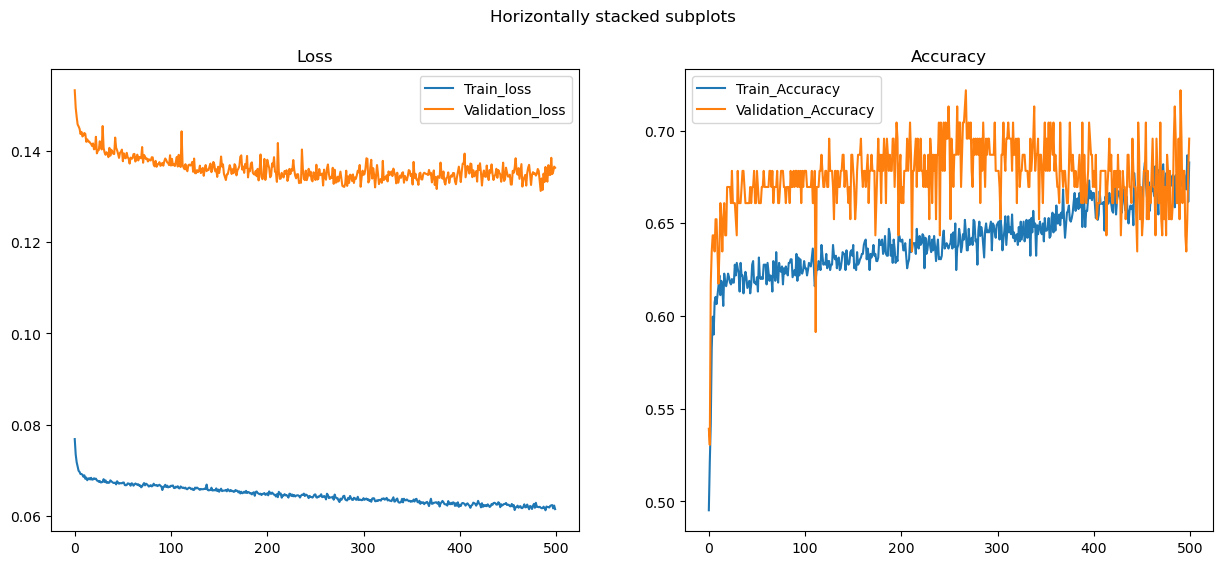

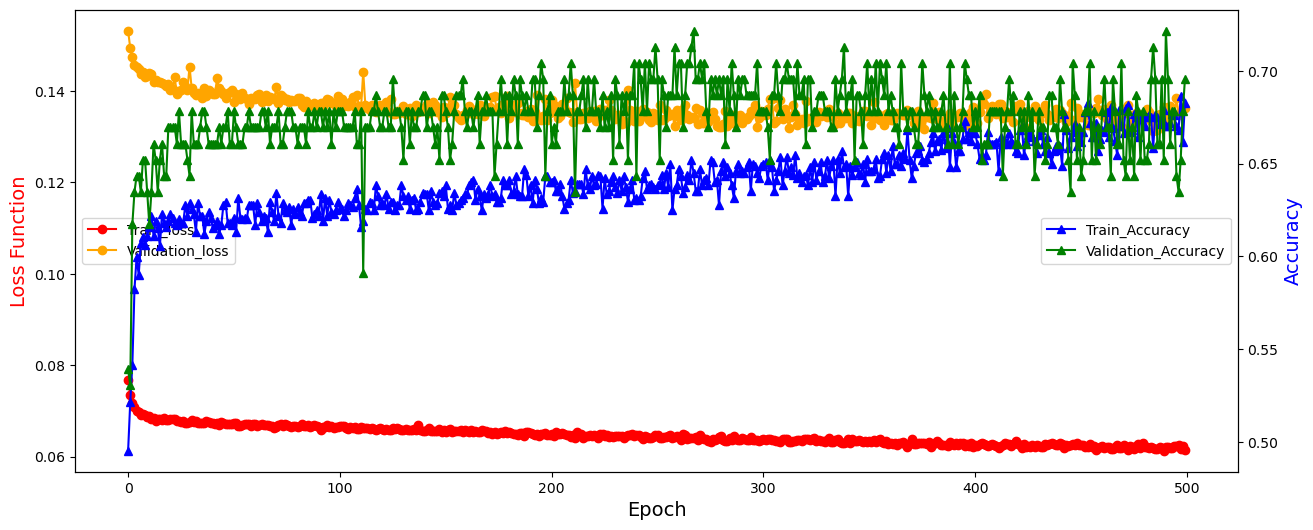

Current time: 98.425 minutes. Time expected till completion: 0.000 minutes
Finished training in: 98.425 minutes


In [15]:
#loader = train_loader # Use the train loader to train
#loader2 = valid_loader
# Main
train_loss, val_loss = [], []
train_accuracy, val_accuracy = [], []

val_loss_withDataAug, val_accuracy_withDataAug = [], []

# Load checkpoints
names = os.listdir(model_checkpoints)
for elem in names:
    if(elem=="metrics_losss_accuracy.csv"):
        print("Loading Metrics")
        dd = pd.read_csv(model_checkpoints + "metrics_losss_accuracy.csv")
        train_loss = dd["train_loss"].tolist()
        val_loss = dd["val_loss"].tolist()
        train_accuracy = dd["train_accuracy"].tolist()
        val_accuracy = dd["val_accuracy"].tolist()
        
# count time
start = time.time()
#PyTorch - Training the Model
for epoch in range(epoch_check, epochs):
    print()
    # Print current epoch
    print(f"Epoch {epoch + 1} of {epochs}")
    
    # Train model
    modelpy.train()
    running_loss=0
    total=0
    correct=0
    # loop for every training batch (one epoch)
    for bi, data in tqdm(enumerate(train_loader), total=len(train_loader)): # use tqdm package to track running time
        # Get the tensors
        images = data[0].to(device)# use the gpu
        labels = data[1].to(device)# use the gpu
        
        # in pytorch you have assign the zero for gradien in any sub epoch
        #optim.zero_grad()
        #create the output from the CNN base on the give batch images
        out = modelpy(images)
        # count the loss function 
        loss = criterion(out, labels)
        
        ######################
        optim.zero_grad()#################
        ######################
        # count the backpropagation
        loss.backward()
        # learning
        optim.step()
        
        # add new value to the main loss
        running_loss += loss.item()
        
        # calculate accuracy
        predictions = torch.argmax(out, dim=1)
        total += labels.size(0)
        correct +=(predictions == labels).sum().item()
        
        
    train_epoch_loss = running_loss/len(train_loader.dataset)
    
    train_epoch_accuracy = correct/total
    
    modelpy.eval()
    running_loss = 0.0
    correct=0
    total=0
    with torch.no_grad():
        for bi, data in tqdm(enumerate(valid_loader), total=len(valid_loader)):
            # Get the tensors
            images = data[0].to(device)# use the gpu
            label = data[1].to(device)# use the gpu
            
            #create the output from the CNN base on the give batch images
            outputs = modelpy(images)
            # count the loss function
            loss = criterion(outputs, label)
            
            # Add loss of each item (total items in a batch = batch size) .
            running_loss += loss.item()
            
            # calculate accuracy
            predictions = torch.argmax(outputs, dim=1)
            total += label.size(0)
            correct +=(predictions == label).sum().item()
            
            
    val_epoch_loss = running_loss/len(valid_loader.dataset) 
    val_epoch_accuracy = correct/total

    
    
    print("train loss: ", train_epoch_loss)
    print("Val loss: ", val_epoch_loss)
    print("train accuracy: ", train_epoch_accuracy)
    print("Val accuracy: ", val_epoch_accuracy)

    
    
    # save results
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    val_accuracy.append(val_epoch_accuracy)

    
    # Save model with all information every 100 epochs. Can be used 
    # resuming training. optim
    if (epoch+1) % checkpoints_save == 0: # checkpoints_save
        # Save Model
        print("Saving model checkpoint")
        end = time.time()
        time_elapsed = (end-start)+previous_time
        save_model(epoch, time_elapsed, modelpy, optim, criterion, path = model_checkpoints + "model_ckpt.pth")
        # save the metrics
        save_metrics(train_loss, val_loss, train_accuracy, val_accuracy, path = model_checkpoints + "metrics_losss_accuracy.csv")
        
        # save model at epoch
        save_model(epoch, time_elapsed, modelpy, optim, criterion, path = model_checkpoints + "model_ckpt_"+str(epoch+1)+".pth")
        
        # Cheack the evolution at this point
        plot_loss_accuracy(train_loss, val_loss, train_accuracy, val_accuracy)
        
        
    ep_time = time.time()
    print(f"Current time: {(((ep_time-start)+previous_time)/60):.3f} minutes. Time expected till completion: {(((((ep_time-start)+previous_time)/(epoch + 1)) * (epochs-(epoch + 1)))/60):.3f} minutes")
    
end = time.time()
print(f"Finished training in: {(((end-start)+previous_time)/60):.3f} minutes") 

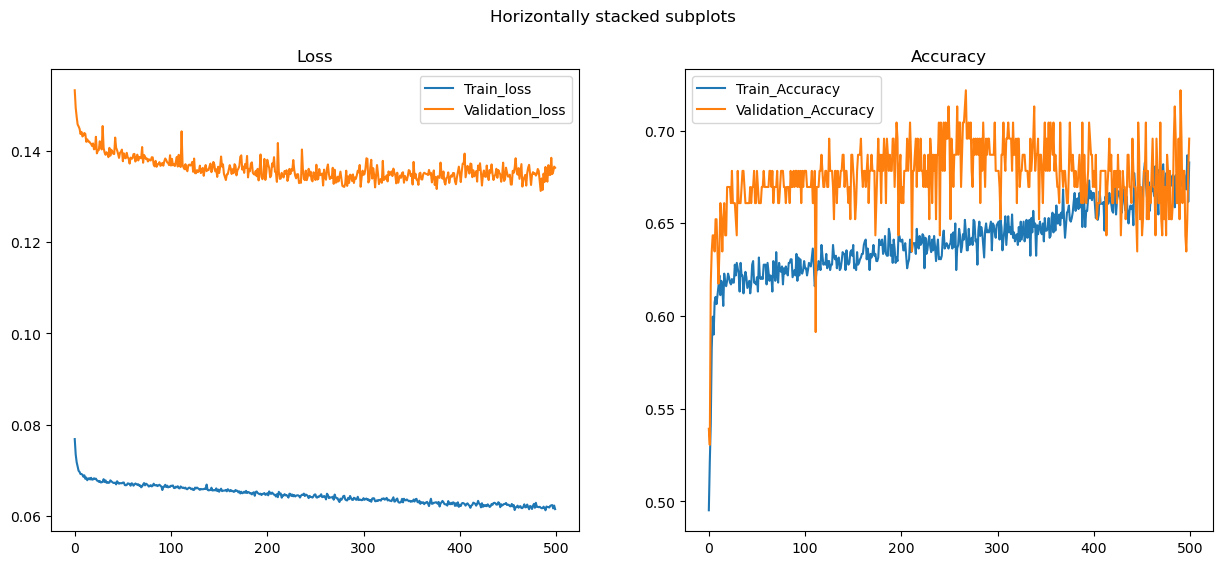

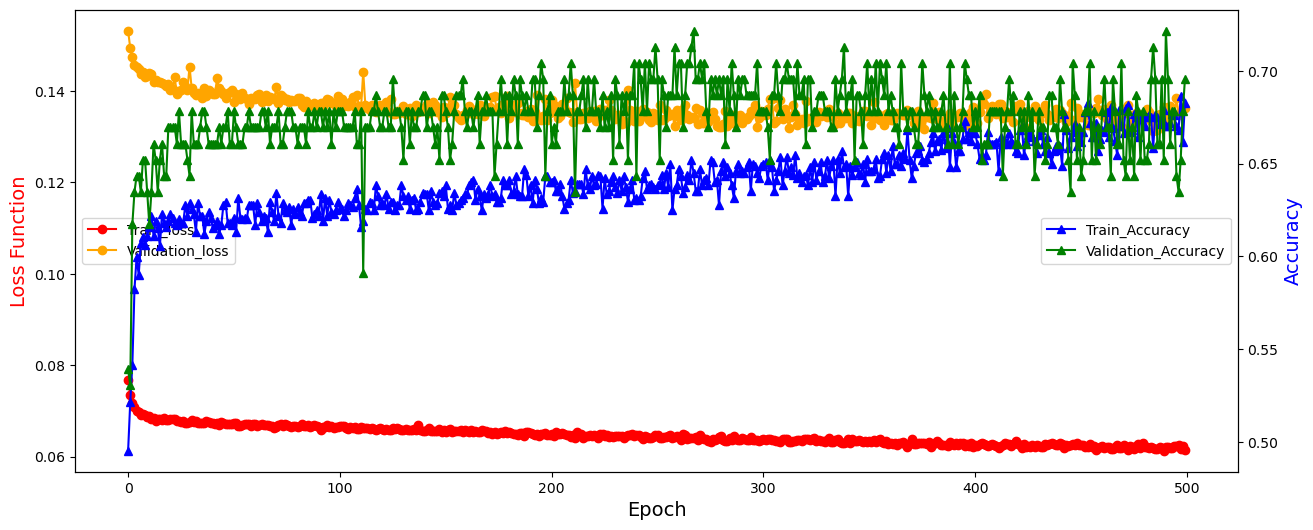

In [16]:
plot_loss_accuracy(train_loss, val_loss, train_accuracy, val_accuracy)

### Save Model

In [17]:
torch.save(modelpy.state_dict(), model_checkpoints + "saved_model_state_dict.pt")
torch.save(modelpy, model_checkpoints + "saved_model.pt")

# 3. Evaluate your model using the developed software

In [18]:
# Calculate accuracy for Validation and Train sets
accuracy_given_set(modelpy, train_loader, device, name="Train")
accuracy_given_set(modelpy, valid_loader, device, name="Validation")

Accuracy of the network on the 1034 Train instances: 70.2127659574468%
Accuracy of the network on the 115 Validation instances: 69.56521739130434%


In [19]:
# Import the test dataset
size_of_resized_img = (224,224) 
test_data, test_names = import_test_folder_dataset_2(test_data_path, resized_side=size_of_resized_img)
print("Dim of Data: ", test_data.shape)
print("Dim of Lables: ", test_names.shape)

Dim of Data:  (380, 224, 224, 3)
Dim of Lables:  (380,)


In [20]:
# Create the dataset object
test_Dataset = Data_test_2(test_data, test_names, img_transform_val)#img_transform_val
print("Test len: ",len(test_Dataset))

Test len:  380


In [21]:
# Make the predictions for the test dataset
predictions_list, names = make_predictions(modelpy=modelpy, dataset=test_Dataset, device=device)
len(predictions_list)

380

In [22]:
# Save the Predictions
save_predictions_as_csv(names=names, predictions=predictions_list, name="04_8Conv_0Res_15FChannels_4Batch.csv")

# 4. Compare results with [SCTL paper](https://www.mdpi.com/2076-2615/12/7/886/htm). Requirement: performance is better than VGG16: 66.8%

# 5. Write a four-page paper report using the shared LaTex template. Upload your paper to ResearchGate or Arxiv, and put your paper link here.

# 6. Grading rubric

(1). Code ------- 20 points (you also need to upload your final model as a pt file)

(2). Grammer ---- 20 points

(3). Introduction & related work --- 10 points

(4). Method  ---- 20 points

(5). Results ---- 20 points

(6). Discussion - 10 points